In [1]:
import os 
from pathlib import Path
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
wd = Path.cwd().parent
path_to_data = [[wd / "input" / "rosenborg-women_a_2020.xlsx", wd / "input" / "rosenborg-women_a_2021.xlsx"],
                [wd / "input" / "vifwomen_a_2020.xlsx", wd / "input" / "vifwomen_a_2021.xlsx"]]
os.chdir(Path.cwd().parent)
from preprocessing.data_loader import generate_teams

In [652]:
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import asdict

In [690]:
import matplotlib.pyplot as plt

In [3]:
teams = generate_teams(path_to_data, ["VI", "Rosenborg"])
players = [player for player in teams["Rosenborg"].players.values()]+[player for player in teams["VI"].players.values()]

In [4]:
attributes = ["fatigue","mood","readiness","sleep_duration","sleep_quality","soreness","stress",]

In [995]:
player = pd.DataFrame([value for attribute, value in asdict(players[0]).items() if attribute in attributes ], index=attributes).T

In [1009]:
class TimeSeries(Dataset):
    def __init__(self, ts, sequence_length, prediction_length):
        self.ts = ts.astype(np.float32)
        self.sequence_length=sequence_length
        sequences = np.row_stack([ts[i*self.sequence_length :(i+1)*self.sequence_length] for i in range(0, int((len(self.ts))/self.sequence_length))])
        prediction_sequences = np.apply_along_axis(lambda x: x[-prediction_length:], axis=1, arr=sequences)
        self.sequences = torch.from_numpy(np.nan_to_num(sequences))
        self.prediction_sequences = torch.from_numpy(np.nan_to_num(prediction_sequences))

        
    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, j):
        return self.sequences[j,:], self.prediction_sequences[j,:]


        
        

In [1052]:
class LSTM(nn.Module):
    def __init__(self, n_hidden, sequence_length):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.lstm1 = nn.LSTMCell(sequence_length, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, sequence_length)
    
    def forward(self, x, future=None):
        outputs = []
        ht1, ct1 = self.lstm1(x.float())
        ht2, ct2 = self.lstm2(ht1)
        output = self.linear(ht2)
        outputs.append(output)
        if future: 
            predictions = []
            for i in range(future):
                ht1, ct1 = self.lstm1(output.float(), (ht1,ct1))
                ht2, ht2 = self.lstm2(ht1, (ht2,ct2))
                output = self.linear(ht2)
                predictions.append(output)
            return torch.cat(predictions, dim=1)
            
        return torch.cat(outputs, dim=1)

In [1053]:
readiness_ts_train = TimeSeries(readiness[:500], sequence_length=10, prediction_length=10)
readiness_ts_test = TimeSeries(readiness[500:], sequence_length=10, prediction_length=10)
num_epochs = 5
batch_size = 10
train_loader = DataLoader(readiness_ts_train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(readiness_ts_test, batch_size=batch_size, shuffle=False)

In [1055]:
model = LSTM(n_hidden=1, sequence_length=10)
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8)


In [1058]:
#Training Loop 
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels.float())
            loss.backward()
            return loss
        optimizer.step(closure)     

y_hats =[]
ys = []
for i, (inputs, labels) in enumerate(test_loader):
        with torch.no_grad():
            future = 1
            pred = model(inputs, future=future)
            loss = criterion(pred, labels)
            y_hat = pred.detach().numpy()
            y_hats.append(y_hat)
            y = labels.detach().numpy()
            ys.append(y)
            print(f"Test Loss {loss.item()}")
            
         

Test Loss 19.480234696672305
Test Loss 24.25828933506432
Test Loss 43.4503932822686


In [1059]:
preds = np.hstack([a[0] for a in y_hats])
ref = np.hstack([a[0] for a in ys])

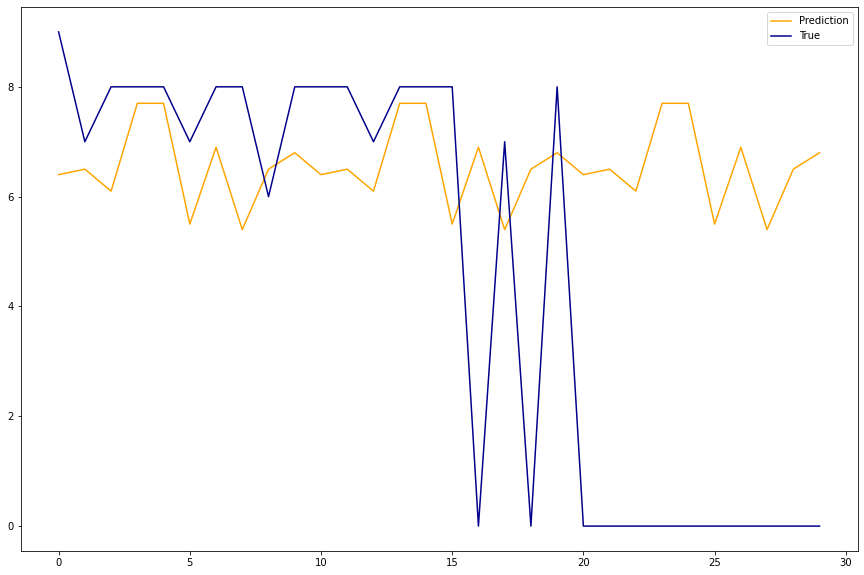

In [1060]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(preds, color = "orange", label= "Prediction")
ax.plot(ref, color = "darkblue", label= "True")
ax.legend()